<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1.-Time-Series-데이터-불러오기-:-KOSPI" data-toc-modified-id="1.-Time-Series-데이터-불러오기-:-KOSPI-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>1. Time Series 데이터 불러오기 : KOSPI</a></span></li><li><span><a href="#2.-전통적인-방법으로-이상치-찾기" data-toc-modified-id="2.-전통적인-방법으로-이상치-찾기-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>2. 전통적인 방법으로 이상치 찾기</a></span><ul class="toc-item"><li><span><a href="#2.1.-z-test" data-toc-modified-id="2.1.-z-test-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>2.1. z-test</a></span></li><li><span><a href="#2.2.-Time-series-decomposition" data-toc-modified-id="2.2.-Time-series-decomposition-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>2.2. Time series decomposition</a></span></li><li><span><a href="#2.3.-신뢰구간" data-toc-modified-id="2.3.-신뢰구간-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>2.3. 신뢰구간</a></span></li></ul></li><li><span><a href="#3.-클러스터링으로-이상치-찾기" data-toc-modified-id="3.-클러스터링으로-이상치-찾기-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>3. 클러스터링으로 이상치 찾기</a></span><ul class="toc-item"><li><span><a href="#3.1.-데이터-전처리" data-toc-modified-id="3.1.-데이터-전처리-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>3.1. 데이터 전처리</a></span></li><li><span><a href="#3.2.-k-means" data-toc-modified-id="3.2.-k-means-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>3.2. k-means</a></span></li><li><span><a href="#3.3.-DBSCAN" data-toc-modified-id="3.3.-DBSCAN-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>3.3. DBSCAN</a></span></li></ul></li><li><span><a href="#4.-Auto-Encoder를-이용한-이상치-탐색" data-toc-modified-id="4.-Auto-Encoder를-이용한-이상치-탐색-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>4. Auto-Encoder를 이용한 이상치 탐색</a></span></li></ul></div>

# 1. Time Series 데이터 불러오기 : KOSPI

In [1]:
import requests
import os

# 아래 url은 yahoo finance 서버에 우리나라 코스피 데이터를 요청하는 주소입니다.
url = "https://query1.finance.yahoo.com/v7/finance/download/%5EKS11?period1=867715200&period2=1597276800&interval=1d&events=history"

# 데이터를 요청하고 그 결과를 response로 받습니다.
response = requests.get(url)

csv_file = os.getenv('HOME')+'/aiffel/anomaly_detection/kospi/kospi.csv'

# response 의 컨텐츠를 csv로 저장합니다.
with open(csv_file, "w") as fp:  
    fp.write(response.text)

In [4]:
# 저장한 csv를 읽어옵니다.
import pandas as pd
df = pd.read_csv(csv_file)
df.head(2)

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-07-01,744.979980,760.520020,744.669983,758.030029,758.030029,0.0
1,1997-07-02,763.390015,777.289978,763.390015,777.289978,777.289978,0.0


In [5]:
# 날짜데이터를 Datetime 형식으로 바꿔줍니다.
df.loc[:,'Date'] = pd.to_datetime(df.Date)

# 데이터의 정합성을 확인합니다
df.isna().sum()

Date           0
Open         150
High         150
Low          150
Close        150
Adj Close    150
Volume       150
dtype: int64

In [6]:
# 결측치 제거
print("삭제 전 데이터 길이(일자수):",len(df))
df = df.dropna(axis=0).reset_index(drop=True)

print("삭제 후 데이터 길이(일자수):",len(df))
df.isna().sum()

삭제 전 데이터 길이(일자수): 5842
삭제 후 데이터 길이(일자수): 5692


Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

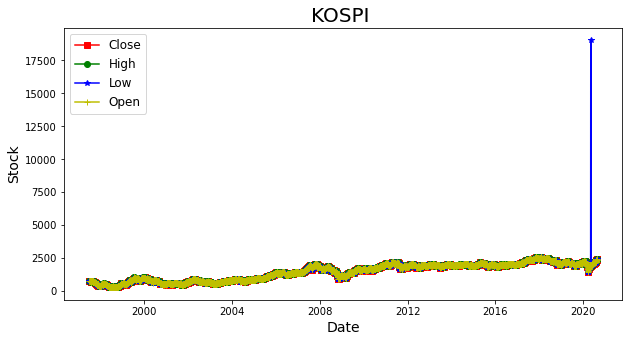

In [7]:
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

plt.rcParams["figure.figsize"] = (10,5)
# Line Graph by matplotlib with wide-form DataFrame

plt.plot(df.Date, df.Close, marker='s', color='r')
plt.plot(df.Date, df.High, marker='o', color='g')
plt.plot(df.Date, df.Low, marker='*', color='b')
plt.plot(df.Date, df.Open, marker='+', color='y')

plt.title('KOSPI ', fontsize=20) 
plt.ylabel('Stock', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.legend(['Close', 'High', 'Low', 'Open'], fontsize=12, loc='best')

plt.show()

In [8]:
# 파란색 이상치 확인
df.loc[df.Low > df.High]

,Date,Open,High,Low,Close,Adj Close,Volume
5620,2020-05-06,1919.449951,1928.76001,19025.550781,1928.76001,1928.76001,1082200.0


# 2. 전통적인 방법으로 이상치 찾기
## 2.1. z-test
데이터가 정규분포를 따를 때, 표준편차(σ)의 배수로 신뢰구간의 상한과 하한을 결정하고 이를 벗어나는 데이터는 이상치로 의심할 수 있다. 단변수의 정규분포 여부는 z-test 방법으로 확인할 수 있다. p 값이 0.05 이하이면 normal distribution과 거리가 멀다는 뜻으로, 이런 데이터에는 정규분포를 가정한 신뢰구간 분석은 적용하기 어려울 것이다.

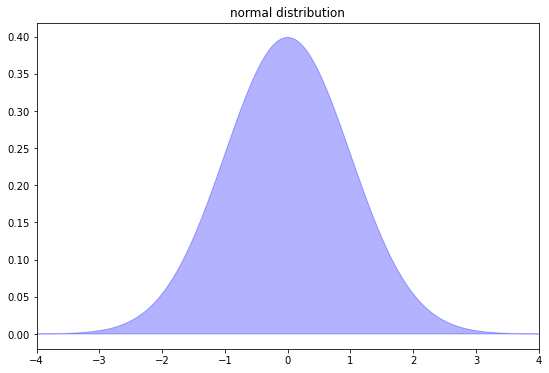

In [9]:
%matplotlib inline
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
x = np.arange(-5, 5, 0.001)
y = norm.pdf(x,0,1) 
# 평균이 0이고, 표준편차가 1인 정규분포를 그립니다.

# build the plot
fig, ax = plt.subplots(figsize=(9,6))
ax.fill_between(x,y,0, alpha=0.3, color='b')
ax.set_xlim([-4,4])
ax.set_title('normal distribution')
plt.show()

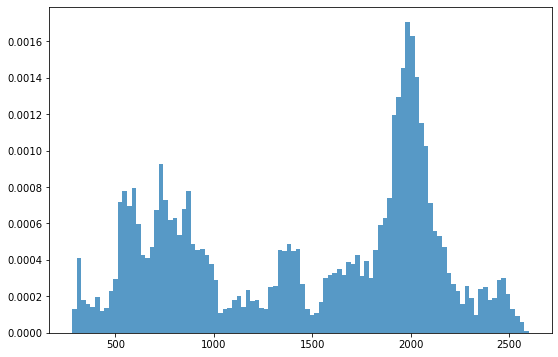

In [10]:
# 종가 데이터 분포 시각화
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(df.Close, 100, density=True, alpha=0.75)

In [11]:
from statsmodels.stats.weightstats import ztest
_, p = ztest(df.Close)
print(p)

0.0


## 2.2. Time series decomposition
기본적으로 평균, 분산, 공분산이 일정한 Stationary 시계열에 대해서만 미래 예측이 가능하다. 하지만 현실의 대부분의 시계열 데이터는 Stationary하지 않고 계속 변화하는 패턴을 보인다. 이때 시계열을 Stationary한 컴포넌트와 Non-stationary한 컴포넌트로 나누어 분석하기 위해 주로 사용하는 기법이 Time series decomposition이다. Time series decomposition을 통해 시계열 데이터는 trend, seasonal, residual 성분으로 분리되고, 그중 Residual 성분의 데이터가 Stationary에 가까운 형태를 가진다. Stationary에 가까운 데이터는 정규분포를 따르므로 Residual 데이터를 사용해서 신뢰구간을 구할 수 있다.

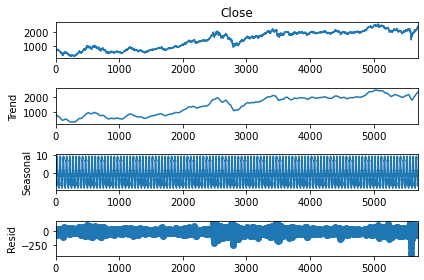

In [12]:
# 종가 데이터 시계열 분해
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df.Close, model='additive', two_sided=True, 
                            period=50, extrapolate_trend='freq') # 계절적 성분의 주기를 50일로 가정
result.plot()
plt.show()

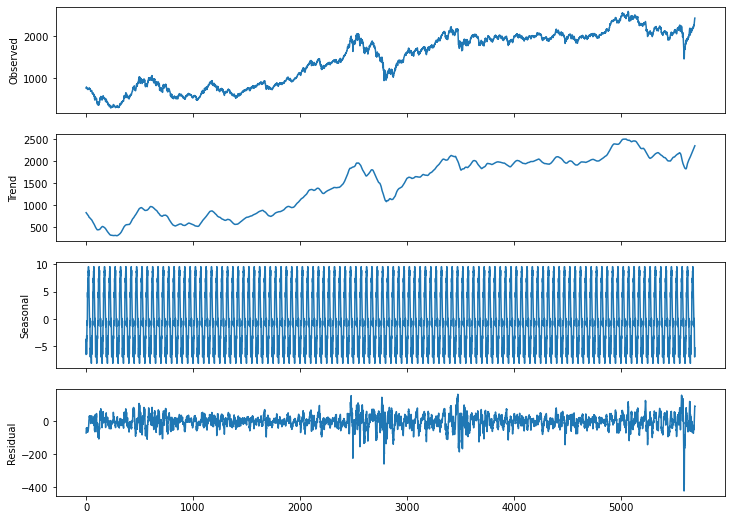

In [13]:
# 그래프가 너무 작아서 안보인다면
fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(12,9))
result.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')
result.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')
result.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
result.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual')
plt.show()

<AxesSubplot:>

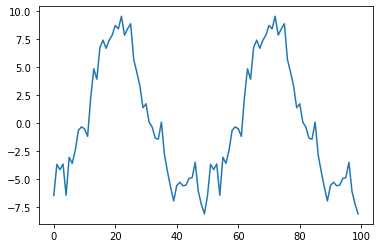

In [14]:
# seasonal 성분은 너무 빼곡하게 보이네요. 다시 확인해보겠습니다.
result.seasonal[:100].plot()
# -8 에서 10 사이를 주기적으로 반복하는게 보이네요.

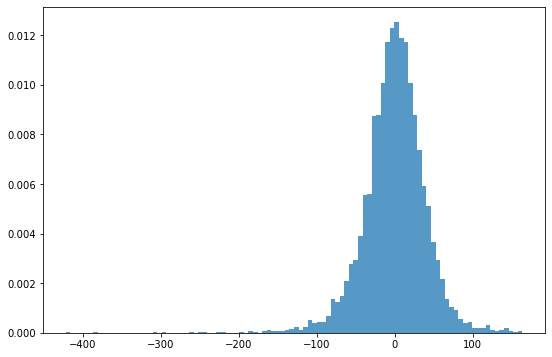

In [15]:
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(result.resid, 100, density=True, alpha=0.75)

In [16]:
r = result.resid.values
st, p = ztest(r)
print(st,p)

-0.6804023554131796 0.4962497300226193


그래프가 0을 기준으로 종 모양으로 분포하고, z-test 결과 p-value가 0.05 이상으로 아주 강하게 나타난다. residual의 분포가 정규분포를 잘 따르고 있다고 볼 수 있다.

## 2.3. 신뢰구간
평균을 기준으로 플러스/마이너스 3σ를 벗어나는 데이터를 찾아본다. 2008년 금융위기 때와 2020년 코로나 위기 시기가 많이 잡혔기 때문에, 극단치(Outlier)보다는 특이치(Novelty)로 보아야 한다.

In [17]:
# 평균과 표준편차 출력
mu, std = result.resid.mean(), result.resid.std()
print("평균:", mu, "표준편차:", std)

# 3-sigma(표준편차)를 기준으로 이상치 판단
print("이상치 갯수:", len(result.resid[(result.resid>mu+3*std)|(result.resid<mu-3*std)]))

평균: -0.3595321143716522 표준편차: 39.8661527194307
이상치 갯수: 71


In [18]:
df.Date[result.resid[
    (result.resid>mu+3*std)|(result.resid<mu-3*std)].index]

2475   2007-07-20
2476   2007-07-23
2477   2007-07-24
2478   2007-07-25
2493   2007-08-16
          ...    
5595   2020-03-26
5596   2020-03-27
5597   2020-03-30
5599   2020-04-01
5642   2020-06-05
Name: Date, Length: 71, dtype: datetime64[ns]

# 3. 클러스터링으로 이상치 찾기
위에서 살펴본 것처럼 하나의 지표만을 사용하는 것이 아니라 다양한 데이터로 Anomalies를 찾아내는 것을 Multi-variable Anomaly Detection이라고 한다. 그 중에서 Clustering 방식은 클러스터링을 통해 정상인 데이터와 이상치가 따로 그룹핑되는 성질을 이용하여 이상치 그룹을 찾는 방법이다.

## 3.1. 데이터 전처리
이번에는 Open, High, Low, Close, Volume 5가지 데이터를 모두 사용해본다. 앞서 살펴본 통계방식과 동일하게 Trend/Seasonal 성분을 제거해야 '정말 튀는' 데이터를 찾아낼 수 있으므로, 5가지 데이터 모두 time series decompose로 전처리를 한다.

In [19]:
# 데이터 전처리
def my_decompose(df, features, freq=50):
    trend = pd.DataFrame()
    seasonal = pd.DataFrame()
    resid = pd.DataFrame()
    
    # 사용할 feature 마다 decompose 를 수행합니다.
    for f in features:
        result = seasonal_decompose(df[f], 
                                    model='additive', period=freq, extrapolate_trend=freq)
        trend[f] = result.trend.values
        seasonal[f] = result.seasonal.values
        resid[f] = result.resid.values
        
    return trend, seasonal, resid

# 각 변수별 트렌드/계절적/잔차
tdf, sdf, rdf = my_decompose(df, features=['Open','High','Low','Close','Volume'])
tdf.describe()

,Open,High,Low,Close,Volume
count,5692.000000,5692.000000,5692.000000,5692.000000,5.692000e+03
mean,1463.295208,1472.280870,1454.276080,1462.541972,4.329729e+06
std,624.964914,625.522910,625.430583,624.550682,9.936646e+06
min,313.251601,317.456402,309.410898,313.594600,0.000000e+00
25%,829.229831,836.772549,819.689776,828.144798,3.367350e+05
50%,1650.375197,1658.997451,1638.522701,1650.718854,4.346625e+05
75%,1994.399103,2000.893924,1986.532475,1992.919778,6.528442e+05
max,2507.482712,2517.003208,2493.430989,2503.484602,4.516467e+07


In [20]:
rdf.describe()

,Open,High,Low,Close,Volume
count,5692.000000,5692.000000,5692.000000,5692.000000,5.692000e+03
mean,-0.401850,-0.380359,0.355350,-0.374020,-1.954065e+02
std,39.589372,38.056752,227.537136,39.872618,8.934869e+06
min,-394.565789,-376.338461,-491.492764,-421.422951,-2.263667e+07
25%,-21.485369,-21.030832,-20.621636,-21.477541,-2.797035e+04
50%,1.389063,1.204421,3.598164,1.088418,1.945293e+05
75%,22.442679,21.891495,25.565665,22.650363,3.611476e+05
max,166.548008,151.359456,16619.216421,163.663209,3.950393e+08


각 변수의 잔차(residual)를 살펴보면 Volume만 너무 숫자가 크다는 걸 알 수 있다. 따라서 한쪽에 쏠리는 걸 제외하기 위해 각 변수들을 표준정규화 해주어야 한다.

In [21]:
# 표준정규화
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(rdf)
print(scaler.mean_)
norm_rdf = scaler.transform(rdf)
norm_rdf

[  -0.40184982   -0.38035856    0.35534954   -0.37402025 -195.40645742]


array([[-2.11078435e+00, -1.81469803e+00, -3.55461884e-01,
        -1.78975878e+00,  2.10763080e-02],
       [-1.57245471e+00, -1.31620670e+00, -2.63587404e-01,
        -1.29206209e+00,  3.44552935e-03],
       [-1.16743672e+00, -1.15447694e+00, -2.11478046e-01,
        -1.24664060e+00, -1.95018959e-04],
       ...,
       [ 1.40187705e+00,  2.03518846e+00,  1.51184809e+00,
         2.10596922e+00,  6.12871509e-02],
       [ 1.72956122e+00,  1.93639106e+00,  1.51714054e+00,
         2.26635573e+00,  3.75265169e-02],
       [ 2.56782539e+00,  2.43952406e+00,  1.61253875e+00,
         2.24061341e+00,  1.51850684e-02]])

## 3.2. k-means
k-means를 이용해서 정상 데이터그룹과 이상치 데이터그룹을 나누기 위해 그룹을 2개로 지정하여 실행해본다.

In [22]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=0).fit(norm_rdf)
print(kmeans.labels_) # 분류된 라벨은 이렇게 kemans.labels_ 로 확인합니다.

[1 1 1 ... 0 0 0]


In [23]:
# 라벨은 몇번 그룹인지 뜻합니다. 
# return_counts=True 를 해서 몇개의 샘플이 몇번 그룹에 할당되었는지 확인해요
lbl, cnt = np.unique(kmeans.labels_,return_counts=True) 
print(lbl) # 0번 그룹, 1번 그룹으로 나뉘어졌네요
print(cnt)

[0 1]
[3278 2414]


어느 한쪽을 이상치 그룹이라고 선택하기에는 양쪽 다 개수가 너무 많으므로 그룹 숫자를 더 늘려서 분석해본다. 3, 4, 5, 12번 그룹의 경우 count가 10개 이내로 매우 특이한 그룹으로 분류되었다. 해당 그룹의 값을 확인해보면 특정 수치가 비정상적으로 크거나 작은 경우임을 알 수 있다.

In [27]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=15, random_state=0).fit(norm_rdf)
lbl, cnt = np.unique(kmeans.labels_,return_counts=True,)
['group:{}-count:{}'.format(group, count) for group, count in zip(lbl, cnt)]

['group:0-count:429',
 'group:1-count:626',
 'group:2-count:1193',
 'group:3-count:1',
 'group:4-count:2',
 'group:5-count:8',
 'group:6-count:195',
 'group:7-count:780',
 'group:8-count:1040',
 'group:9-count:73',
 'group:10-count:58',
 'group:11-count:967',
 'group:12-count:2',
 'group:13-count:255',
 'group:14-count:63']

In [28]:
# 꼭 여러분들의 분류 결과에서 특이 그룹으로 분류된 그룹 번호로 바꿔 주세요. 
df[(kmeans.labels_==3)|(kmeans.labels_==4)|(kmeans.labels_==5)|(kmeans.labels_==12)]

,Date,Open,High,Low,Close,Adj Close,Volume
1607,2004-01-20,854.030029,864.260010,853.049988,861.369995,861.369995,364449900.0
1663,2004-04-14,909.950012,919.380005,907.359985,916.309998,916.309998,407157000.0
2737,2008-08-14,1553.650024,1578.300049,1553.650024,1572.189941,1572.189941,247586000.0
2738,2008-08-18,1579.130005,1582.760010,1561.569946,1567.709961,1567.709961,260725000.0
2786,2008-10-27,937.179993,966.409973,892.159973,946.450012,946.450012,540600.0
2787,2008-10-28,916.849976,1012.729980,901.489990,999.159973,999.159973,649400.0
5588,2020-03-17,1640.839966,1722.969971,1637.880005,1672.439941,1672.439941,649800.0
5589,2020-03-18,1686.119995,1693.949951,1591.119995,1591.199951,1591.199951,728000.0
5590,2020-03-19,1626.089966,1626.089966,1439.430054,1457.640015,1457.640015,977700.0
5591,2020-03-20,1498.489990,1566.819946,1466.479980,1566.150024,1566.150024,817000.0


In [29]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5692.000000,5692.000000,5692.000000,5692.000000,5692.000000,5.692000e+03
mean,1462.901104,1471.908189,1454.644994,1462.175989,1462.175989,4.329776e+06
std,627.457157,627.898094,667.839926,627.087928,627.087928,1.351615e+07
min,283.410004,291.010010,277.369995,280.000000,280.000000,0.000000e+00
25%,827.972473,836.750000,815.689987,826.737503,826.737503,3.126000e+05
50%,1652.270019,1658.365051,1633.690002,1646.915039,1646.915039,4.103000e+05
75%,1999.605011,2006.892517,1988.872498,1997.255005,1997.255005,6.145500e+05
max,2590.409912,2607.100098,19025.550781,2598.189941,2598.189941,4.071570e+08


In [30]:
# 2004-04-14 주변 정황
df.iloc[1660:1670]

,Date,Open,High,Low,Close,Adj Close,Volume
1660,2004-04-09,910.479980,910.479980,901.239990,905.440002,905.440002,352200.0
1661,2004-04-12,905.440002,926.070007,905.440002,918.859985,918.859985,366200.0
1662,2004-04-13,925.190002,927.669983,916.200012,917.630005,917.630005,469000.0
1663,2004-04-14,909.950012,919.380005,907.359985,916.309998,916.309998,407157000.0
1664,2004-04-16,903.840027,908.719971,897.729980,898.880005,898.880005,391800.0
1665,2004-04-19,900.479980,902.099976,891.270020,902.099976,902.099976,476200.0
1666,2004-04-20,909.909973,919.130005,902.469971,918.900024,918.900024,456800.0
1667,2004-04-21,910.679993,931.210022,910.679993,929.950012,929.950012,554000.0
1668,2004-04-22,931.090027,933.840027,921.969971,924.010010,924.010010,519800.0
1669,2004-04-23,938.250000,939.520020,929.799988,936.059998,936.059998,480400.0


In [31]:
# 각 그룹의 중심부는 어떤 값을 가지고 있는지 확인해보겠습니다.
pd.DataFrame(kmeans.cluster_centers_, columns=['Open','High','Low','Close','Volume'])

,Open,High,Low,Close,Volume
0,-1.243278,-1.276624,-0.223654,-1.253905,-0.108433
1,1.060311,1.081258,0.185514,1.053527,-0.007158
2,0.137352,0.139485,0.018323,0.140947,-0.056685
3,-0.382053,-0.606259,73.044433,-0.223380,0.025532
4,0.684927,0.795780,0.157240,0.852334,41.913921
5,-7.397073,-6.966336,-1.368214,-7.181657,-0.037365
6,-1.971087,-2.000448,-0.380427,-1.941378,-0.110404
7,-0.731611,-0.744841,-0.136558,-0.702768,-0.061373
8,-0.268998,-0.291791,-0.058534,-0.283195,-0.059295
9,0.466959,0.566319,0.064445,0.497133,1.522659


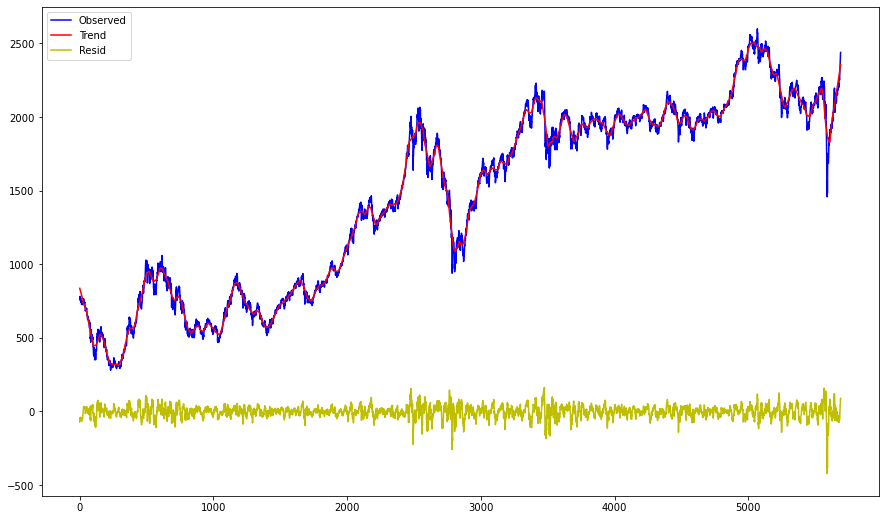

In [32]:
fig = plt.figure(figsize=(15,9))
ax = fig.add_subplot(111)
df.Close.plot(ax=ax, label='Observed', legend=True, color='b')
tdf.Close.plot(ax=ax, label='Trend', legend=True, color='r')
rdf.Close.plot(ax=ax,label='Resid', legend=True, color='y')
plt.show()

## 3.3. DBSCAN
K-means와 달리, DBSCAN 알고리즘은 클러스터의 개수를 지정할 필요가 없다. DBSCAN 알고리즘은 핵심벡터와 일정 거리 ϵ 이내인 데이터 벡터들이 군집(Cluster)을 이루게 하는데, 그러한 군집들과 거리상 동떨어져 군집에 들지 못하는 특이한 데이터들을 노이즈(Noise) 벡터라고 부른다. DBSCAN을 통해 이상치를 찾는 것은 바로 이러한 노이즈 벡터를 찾는 것과 같다.

In [33]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=0.7, min_samples=2).fit(norm_rdf)
clustering

DBSCAN(eps=0.7, min_samples=2)

In [34]:
# 분류된 라벨들은 이렇게 확인할 수 있어요
print(clustering.labels_)

[ 0  0  0 ... 10 10 -1]


In [35]:
lbl, cnt = np.unique(clustering.labels_,return_counts=True)
['group:{}-count:{}'.format(group, count) for group, count in zip(lbl, cnt)]

['group:-1-count:44',
 'group:0-count:5595',
 'group:1-count:2',
 'group:2-count:2',
 'group:3-count:4',
 'group:4-count:2',
 'group:5-count:30',
 'group:6-count:3',
 'group:7-count:3',
 'group:8-count:3',
 'group:9-count:2',
 'group:10-count:2']

# 4. Auto-Encoder를 이용한 이상치 탐색
Forecasting 방식은 시계열 예측모델을 만들어서 예측 오차가 크게 발생하는 지점을 이상치로 찾아내는 방식이다. 여기에 사용되는 Auto-Encoder는 인코더와 디코더로 구성된다. 인코더는 입력데이터로부터 중요한 정보(Compressed Feature Vector)를 뽑아내고, 디코더는 중요한 정보로부터 입력데이터와 유사한 형태를 재생성(Generate)한다. 인코더가 중요한 정보를 잘 뽑아내면 디코더는 입력데이터를 거의 똑같이 생성해낼 수 있겠지만 비정상적인 데이터들은 똑같이 생성하기 어렵다는 원리를 이용한다.

In [36]:
# 필요한 라이브러리를 불러옵니다
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [37]:
# 모델 재현성을 위해 난수 시드설정을 해줍니다
tf.random.set_seed(777)
np.random.seed(777)

In [38]:
from sklearn.preprocessing import StandardScaler

# 데이터 전처리 - 하이퍼 파라미터
window_size = 10
batch_size = 32
features = ['Open','High','Low','Close','Volume']
n_features = len(features)
TRAIN_SIZE = int(len(df)*0.7)

# 데이터 전처리 - 표준정규분포화
scaler = StandardScaler()
scaler = scaler.fit(df.loc[:TRAIN_SIZE,features].values)
scaled = scaler.transform(df[features].values)

In [39]:
# keras TimeseriesGenerator 를 이용해서 간편하게 데이터 셋을 만듭니다
train_gen = TimeseriesGenerator(
    data = scaled,         # 입력데이터: 'Open','High','Low','Close','Volume'
    targets = scaled,      # 출력데이터: 5가지 인풋 그대로 예측하므로 data와 동일
    length = window_size,  # 몇 개의 time_step을 참고할지
    stride=1,              # time_step 사이즈
    sampling_rate=1,
    batch_size= batch_size,
    shuffle=False,
    start_index=0,
    end_index=None,
)

valid_gen = TimeseriesGenerator(
    data = scaled,
    targets = scaled,
    length = window_size,
    stride=1,
    sampling_rate=1,
    batch_size=batch_size,
    shuffle=False,
    start_index=TRAIN_SIZE,
    end_index=None,
)

print(train_gen[0][0].shape)
print(train_gen[0][1].shape)

(32, 10, 5)
(32, 5)


In [40]:
# LSTM을 이용한 오토인코더 모델 만들기
model = Sequential([
    # 인코더
    LSTM(64, activation='relu', return_sequences=True, 
         input_shape=(window_size, n_features)),
    LSTM(16, activation='relu', return_sequences=False),
    # Bottleneck: input을 window_size 만큼 복사
    RepeatVector(window_size),
    # 디코더
    LSTM(16, activation='relu', return_sequences=True),
    LSTM(64, activation='relu', return_sequences=False),
    Dense(n_features)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 64)            17920     
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                5184      
_________________________________________________________________
repeat_vector (RepeatVector) (None, 10, 16)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 16)            2112      
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                20736     
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 46,277
Trainable params: 46,277
Non-trainable params: 0
____________________________________________________

In [41]:
# 체크포인트
# 학습을 진행하며 validation 결과가 가장 좋은 모델을 저장해둠
import os

checkpoint_path = os.getenv('HOME')+'/aiffel/anomaly_detection/kospi/mymodel.ckpt'
checkpoint = ModelCheckpoint(checkpoint_path, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss',
                             verbose=1)

# 얼리스탑
# 학습을 진행하며 validation 결과가 나빠지면 스톱. patience 횟수만큼은 참고 지켜본다

early_stop = EarlyStopping(monitor='val_loss', patience=5)

model.compile(loss='mae', optimizer='adam', metrics=["mae"])

In [42]:
hist = model.fit(train_gen, 
          validation_data=valid_gen,
          steps_per_epoch=len(train_gen),
          validation_steps=len(valid_gen),
          epochs=50, 
          callbacks=[checkpoint, early_stop])

Epoch 1/50
177/178 [============================>.] - ETA: 0s - loss: 0.4706 - mae: 0.4706
Epoch 00001: val_loss improved from inf to 0.09613, saving model to /home/ssac21/aiffel/anomaly_detection/kospi/mymodel.ckpt
178/178 [==============================] - 7s 40ms/step - loss: 0.4683 - mae: 0.4683 - val_loss: 0.0961 - val_mae: 0.0961
Epoch 2/50
177/178 [============================>.] - ETA: 0s - loss: 0.1496 - mae: 0.1496
Epoch 00002: val_loss did not improve from 0.09613
178/178 [==============================] - 7s 37ms/step - loss: 0.1495 - mae: 0.1495 - val_loss: 0.1459 - val_mae: 0.1459
Epoch 3/50
177/178 [============================>.] - ETA: 0s - loss: 0.1472 - mae: 0.1472
Epoch 00003: val_loss improved from 0.09613 to 0.08293, saving model to /home/ssac21/aiffel/anomaly_detection/kospi/mymodel.ckpt
178/178 [==============================] - 6s 36ms/step - loss: 0.1478 - mae: 0.1478 - val_loss: 0.0829 - val_mae: 0.0829
Epoch 4/50
177/178 [============================>.] - ET

In [43]:
model.load_weights(checkpoint_path)

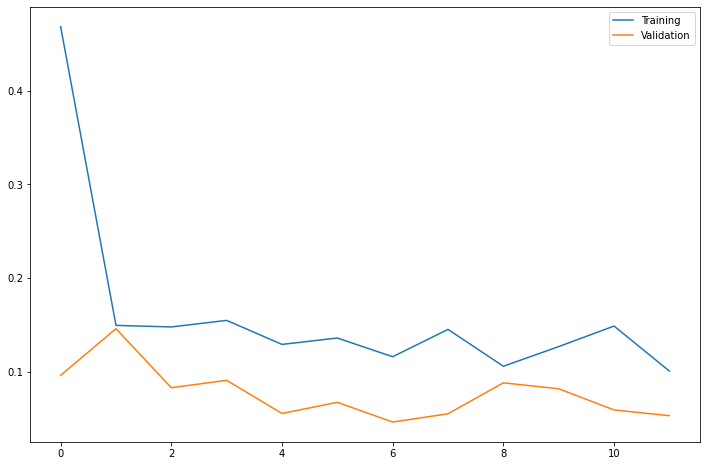

In [44]:
fig = plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'], label='Training')
plt.plot(hist.history['val_loss'], label='Validation')
plt.legend()

시계열 데이터를 window_size 만큼 밀어가면서 예측하는 모델을 만들었기 때문에 train_gen의 길이는 원본 df의 길이보다 window_size 만큼 짧다. 예측 결과와 비교할 때는 scaled의 앞에서 window_size 만큼을 건너뛰어야 한다.

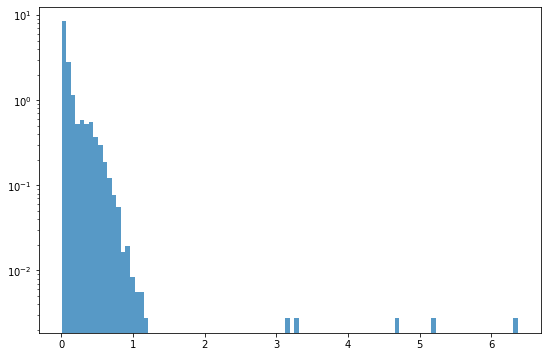

In [45]:
# 예측 결과를 pred로, 실적 데이터를 real로 받습니다
pred = model.predict(train_gen)
real = scaled[window_size:]

mae_loss = np.mean(np.abs(pred-real), axis=1)

# 샘플 개수가 많기 때문에 y축을 로그 스케일로 그립니다
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(mae_loss, 100, density=True, alpha=0.75, log=True)

위 그래프에서 mae_loss가 3 이상으로 동떨어진 샘플이 몇 개 보인다. 기존의 df와 mae_loss를 합친 데이터프레임을 만들고, mae_loss의 기준치를 3으로 설정하면 그래프에서 동떨어진 5개의 이상치를 찾을 수 있다. 기준치를 더 낮추면 보다 많은 이상치를 찾아낼 수 있다.

In [46]:
import copy

test_df = copy.deepcopy(df.loc[window_size:]).reset_index(drop=True)
test_df['Loss'] = mae_loss

threshold = 3
test_df.loc[test_df.Loss>threshold]

,Date,Open,High,Low,Close,Adj Close,Volume,Loss
1597,2004-01-20,854.030029,864.260010,853.049988,861.369995,861.369995,364449900.0,4.672492
1653,2004-04-14,909.950012,919.380005,907.359985,916.309998,916.309998,407157000.0,5.193633
2727,2008-08-14,1553.650024,1578.300049,1553.650024,1572.189941,1572.189941,247586000.0,3.126651
2728,2008-08-18,1579.130005,1582.760010,1561.569946,1567.709961,1567.709961,260725000.0,3.294964
5610,2020-05-06,1919.449951,1928.760010,19025.550781,1928.760010,1928.760010,1082200.0,6.371629


In [47]:
threshold = 0.3
test_df.loc[test_df.Loss>threshold]

,Date,Open,High,Low,Close,Adj Close,Volume,Loss
74,1997-11-04,514.080017,542.859985,514.080017,542.130005,542.130005,0.0,0.311578
75,1997-11-05,547.330017,565.159973,546.299988,555.739990,555.739990,0.0,0.362192
76,1997-11-06,555.210022,558.250000,544.530029,553.869995,553.869995,0.0,0.369056
77,1997-11-07,554.380005,554.739990,514.940002,515.630005,515.630005,0.0,0.349994
78,1997-11-10,501.450012,526.599976,501.450012,525.320007,525.320007,0.0,0.322642
...,...,...,...,...,...,...,...,...
5616,2020-05-14,1922.439941,1931.430054,1913.489990,1924.959961,1924.959961,760600.0,0.302623
5617,2020-05-15,1937.630005,1938.589966,1913.209961,1927.280029,1927.280029,866400.0,0.343969
5618,2020-05-18,1934.510010,1943.069946,1921.140015,1937.109985,1937.109985,761700.0,0.356805
5619,2020-05-19,1977.469971,1983.770020,1968.589966,1980.609985,1980.609985,773400.0,0.399783


Open, Close, Low, High 데이터는 스케일이 비슷하니 한 번에 그리고, Volume과 loss는 스케일이 다르니 각각 그래프를 그려본다. 기준치로 분류해낸 이상치들은 붉은 점으로 나타내본다.

/home/ssac21/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/lines.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return Path(verts[markevery], _slice_or_none(codes, markevery))


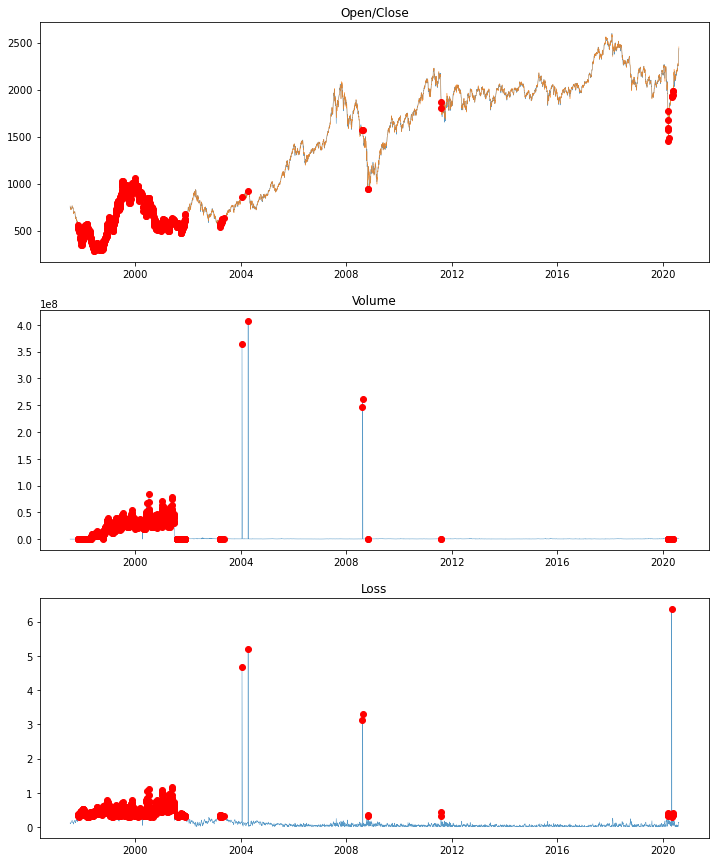

In [48]:
fig = plt.figure(figsize=(12,15))

# 가격들 그래프입니다
ax = fig.add_subplot(311)
ax.set_title('Open/Close')
plt.plot(test_df.Date, test_df.Close, linewidth=0.5, alpha=0.75, label='Close')
plt.plot(test_df.Date, test_df.Open, linewidth=0.5, alpha=0.75, label='Open')
plt.plot(test_df.Date, test_df.Close, 'or', markevery=[mae_loss>threshold])

# 거래량 그래프입니다
ax = fig.add_subplot(312)
ax.set_title('Volume')
plt.plot(test_df.Date, test_df.Volume, linewidth=0.5, alpha=0.75, label='Volume')
plt.plot(test_df.Date, test_df.Volume, 'or', markevery=[mae_loss>threshold])

# 오차율 그래프입니다
ax = fig.add_subplot(313)
ax.set_title('Loss')
plt.plot(test_df.Date, test_df.Loss, linewidth=0.5, alpha=0.75, label='Loss')
plt.plot(test_df.Date, test_df.Loss, 'or', markevery=[mae_loss>threshold])